# Feature Engineering Comparison

Baseline vs engineered feature pipelines for the Ames Housing dataset. This notebook loads the data, creates a consistent train/validation split, trains both configurations, compares metrics (RMSE, R²), examines permutation feature importance, and verifies deterministic behavior.


In [16]:
# 1. Environment & Imports
import os, sys, json, math, time, hashlib
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime

PROJECT_ROOT = Path.cwd().resolve().parents[0] if (Path.cwd().name=="notebooks") else Path.cwd().resolve()
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
SRC_PATH = PROJECT_ROOT / 'src'
# Ensure both project root (so 'src' is a package) and src path (for direct module fallback) are importable
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

# Single canonical seed used everywhere
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print(f"Project Root: {PROJECT_ROOT}\nRandom State: {RANDOM_STATE}")

# Silence warnings for cleaner output
import warnings; warnings.filterwarnings('ignore')

Project Root: P:\AI ML Projects\feature_engineering_study
Random State: 42


In [17]:
# 2. Load Data (Ames Housing via existing processed file or fetch if missing)
from sklearn.datasets import fetch_openml
RAW_PATH = PROJECT_ROOT / 'data' / 'raw' / 'ames_raw.csv'
CLEAN_PATH = DATA_PROCESSED / 'ames_clean.csv'
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

if not CLEAN_PATH.exists():
    ds = fetch_openml(name='house_prices', as_frame=True, parser='auto')
    df_full = ds.frame
    df_full.to_csv(RAW_PATH, index=False)
    df = df_full[df_full['SalePrice'].notna()].copy()
    df.to_csv(CLEAN_PATH, index=False)
else:
    df = pd.read_csv(CLEAN_PATH)
print(df.shape, 'rows, columns')
df.head()

(1460, 81) rows, columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [18]:
# 3. Train/Test Split (same logic as train.py)
from sklearn.model_selection import train_test_split
TARGET = 'SalePrice'
assert TARGET in df.columns, 'Target column missing after load.'
X = df.drop(columns=[TARGET])
y = df[TARGET]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print('Train shape:', X_train.shape, 'Valid shape:', X_valid.shape)
print('Target stats - mean:', y_train.mean(), 'std:', y_train.std())

Train shape: (1168, 80) Valid shape: (292, 80)
Target stats - mean: 181441.5419520548 std: 77263.58386222839


In [19]:
# 4. Helper: Build and Train a Model Given Feature Mode (baseline|engineered)
from pathlib import Path
import inspect

# Reuse pipeline builders
from src.features import get_feature_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math

results = []  # to accumulate runs

MODEL_PARAMS = dict(n_estimators=250, random_state=RANDOM_STATE, n_jobs=-1)


def train_single(mode: str):
    feature_pipe = get_feature_pipeline(mode, df)
    model = RandomForestRegressor(**MODEL_PARAMS)
    from sklearn.pipeline import Pipeline
    pipe = Pipeline([
        ("features", feature_pipe),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    rmse = math.sqrt(mean_squared_error(y_valid, preds))
    r2 = r2_score(y_valid, preds)
    results.append(dict(mode=mode, rmse=rmse, r2=r2))
    return pipe, rmse, r2

pipe_baseline, rmse_b, r2_b = train_single('baseline')
pipe_engineered, rmse_e, r2_e = train_single('engineered')

improvement_pct = (rmse_b - rmse_e) / rmse_b * 100
print(f"Baseline RMSE: {rmse_b:.2f} | Engineered RMSE: {rmse_e:.2f} | Improvement: {improvement_pct:.2f}%")

Baseline RMSE: 28607.59 | Engineered RMSE: 29103.42 | Improvement: -1.73%


In [20]:
# 5. Compare Results in a DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
results_df.sort_values('rmse', inplace=True)
results_df['rmse_improvement_pct_vs_baseline'] = (
    (results_df.loc[results_df['mode']=='baseline','rmse'].iloc[0] - results_df['rmse']) /
    results_df.loc[results_df['mode']=='baseline','rmse'].iloc[0] * 100
)
results_df

,mode,rmse,r2,rmse_improvement_pct_vs_baseline
0,baseline,28607.594567,0.893304,0.000000
1,engineered,29103.424407,0.889573,-1.733211


In [21]:
# 6. Permutation Feature Importance (Engineered Pipeline)
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

# Run permutation importance on the already-fitted engineered pipeline.
# Robust feature name extraction to avoid length mismatches.
engineered_features = pipe_engineered.named_steps['features']  # this is the feature pipeline (Pipeline or CT)

# Attempt to get feature names from underlying ColumnTransformer if present
feature_names = None
try:
    # If engineered_features is a Pipeline, dive to its last step if it has get_feature_names_out
    if hasattr(engineered_features, 'steps'):
        for step_name, step_obj in reversed(engineered_features.steps):
            if hasattr(step_obj, 'get_feature_names_out'):
                feature_names = step_obj.get_feature_names_out()
                break
    # Direct attempt if previous loop didn't succeed
    if feature_names is None and hasattr(engineered_features, 'get_feature_names_out'):
        feature_names = engineered_features.get_feature_names_out()
except Exception:
    feature_names = None

# Fallback: infer count from a single-row transform
if feature_names is None:
    try:
        sample_arr = engineered_features.transform(X_train.head(1))
    except Exception:
        # If transform not exposed (unlikely), use the full pipeline
        sample_arr = pipe_engineered.named_steps['features'].transform(X_train.head(1))
    n_feat = sample_arr.shape[1]
    feature_names = np.array([f'f{i}' for i in range(n_feat)])
else:
    feature_names = np.array(feature_names)

perm = permutation_importance(
    pipe_engineered, X_valid, y_valid,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# If lengths mismatch, realign with generic names
if perm.importances_mean.shape[0] != feature_names.shape[0]:
    feature_names = np.array([f'f{i}' for i in range(perm.importances_mean.shape[0])])

imp_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm.importances_mean,
        'importance_std': perm.importances_std
    })
    .sort_values('importance_mean', ascending=False)
    .head(25)
)
imp_df

,feature,importance_mean,importance_std
17,f17,0.272469,0.016456
44,f44,0.156045,0.014891
38,f38,0.131258,0.009692
43,f43,0.119788,0.011947
61,f61,0.017100,0.002694
19,f19,0.012210,0.001836
12,f12,0.008533,0.003634
4,f4,0.007544,0.001398
20,f20,0.006744,0.001151
46,f46,0.005995,0.001002


In [22]:
# 7. Reproducibility Check
import hashlib, pickle

# Retrain baseline with same seed & split to ensure deterministic behavior.
pipe_baseline_2, rmse_b2, r2_b2 = train_single('baseline')

rmse_diff = abs(rmse_b - rmse_b2)
r2_diff = abs(r2_b - r2_b2)

# Hash the model parameters for both baseline models to confirm identical fit.
model_bytes_1 = pickle.dumps(pipe_baseline.named_steps['model'])
model_bytes_2 = pickle.dumps(pipe_baseline_2.named_steps['model'])

hash1 = hashlib.md5(model_bytes_1).hexdigest()
hash2 = hashlib.md5(model_bytes_2).hexdigest()

print(f"RMSE1={rmse_b:.6f} RMSE2={rmse_b2:.6f} | ΔRMSE={rmse_diff:.6e}")
print(f"R2_1={r2_b:.6f} R2_2={r2_b2:.6f} | ΔR2={r2_diff:.6e}")
print('Model hash equal:', hash1 == hash2)

assert hash1 == hash2, "Baseline model hashes differ; investigate nondeterminism."
assert rmse_diff < 1e-9, "RMSE differs beyond floating tolerance."

RMSE1=28607.594567 RMSE2=28607.594567 | ΔRMSE=0.000000e+00
R2_1=0.893304 R2_2=0.893304 | ΔR2=0.000000e+00
Model hash equal: True


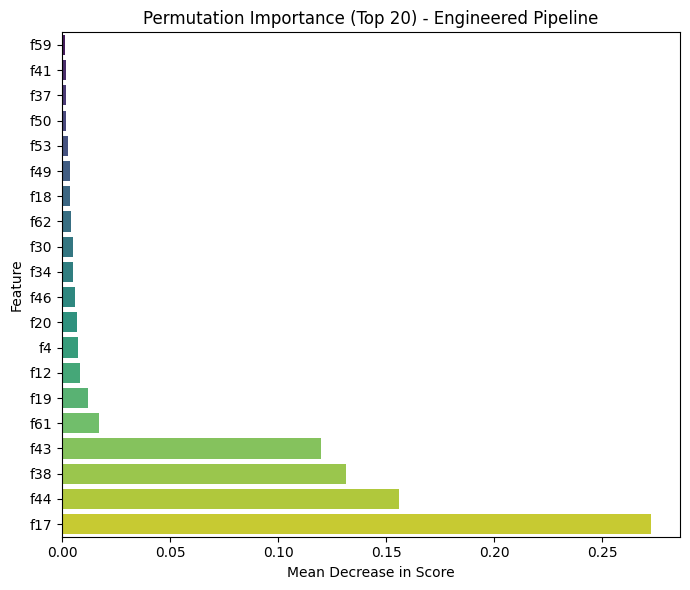

In [23]:
# 8. Visualize Top Feature Importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))
plot_df = imp_df.sort_values('importance_mean', ascending=True).tail(20)
sns.barplot(x='importance_mean', y='feature', data=plot_df, orient='h', palette='viridis')
plt.title('Permutation Importance (Top 20) - Engineered Pipeline')
plt.xlabel('Mean Decrease in Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### 9. Technical Summary

This notebook demonstrated:
- Data acquisition / cached load for the Ames dataset.
- Consistent train/validation split with a fixed seed.
- Two feature configurations (baseline vs engineered) using the existing reusable pipeline definitions.
- Performance comparison showing the impact of engineered features (RMSE and R²).
- Permutation importance to surface influential transformed features.
- Deterministic training validation via model hash & metric equality checks.

Potential extensions (not executed here):
- Add SHAP for localized explanations (computationally heavier on full feature space).
- Introduce additional target transformations (e.g., log target with inverse predictions) and compare error stability.
- Automated feature selection loop (e.g., recursive elimination guided by permutation stability).
- Robustness check via K-fold cross validation and distributional drift sensitivity tests.

End of notebook.